# Simple Bayesian network, iterative learning

Same model as before, but learning proceeds iterative. That is, the parameters are updated after each trial, rather than after the complete batch of data points. Note that it is designed to work for an indefinite number of trials. It is therefore not equivalent to the batch-learning formulation.

In [2]:
from simple_bayesiannetwork_iterative import *
import numpy as np
import common as c
import matplotlib.pyplot as plt

## Generate training data

The data is generated in the same was as with the previous model.

In [3]:
# Number of data points
numN = 200000

# Define true model
cfg = c.Cfg()
cfg.A1 = np.array([0.2, 0.8])
cfg.A2 = np.array([[0.7, 0.3], [0.5, 0.5]])
cfg.A3 = np.array([[[0.1, 0.9], [1/3, 2/3]], [[1/3, 2/3], [0.9, 0.1]]])
cfg.mu = np.eye(8).reshape((2, 2, 2, 8))

model0 = Model(cfg)

# Generate data
X = model0.generate_data(numN)

# Display some data
X[0:10, :]

array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

## Train new model

The to-be-trained model is initialized with random parameters.

In [4]:
cfg = c.Cfg()
cfg.A1 = generate_random_probability_matrix((2))
cfg.A2 = generate_random_probability_matrix((2, 2))
cfg.A3 = generate_random_probability_matrix((2, 2, 2))
cfg.mu = np.random.random((2, 2, 2, 8))

model1 = Model(cfg)

gamma = 0.001                            # Learning parameter

log1 = c.Empty()
log1.ll = np.zeros(numN)                 # Log-likelihood
log1.m_ll = np.zeros(numN)               # Moving average log-likelihood
log1.A1 = np.zeros((numN, 2))
log1.A2 = np.zeros((numN, 2, 2))
log1.A3 = np.zeros((numN, 2, 2, 2))
log1.mu = np.zeros((numN, 2, 2, 2, 8))

for nn in range(0, numN):
    log1.A1[nn, :] = model1.A1
    log1.A2[nn, :, :] = model1.A2
    log1.A3[nn, :, :, :] = model1.A3
    log1.mu[nn, :, :, :, :] = model1.mu

    x = X[nn, :]
    (p, ll) = model1.infer(x)
    log1.ll[nn] = ll
    log1.m_ll[nn] = log1.ll[max(0, nn-100):(nn+1)].mean()

    model1.learn(p, x, gamma)
    
    if (nn % 10000) == 0:
        print(f'Finished trial {nn}/{numN}')

Finished trial 0/200000
Finished trial 10000/200000
Finished trial 20000/200000
Finished trial 30000/200000
Finished trial 40000/200000
Finished trial 50000/200000
Finished trial 60000/200000
Finished trial 70000/200000
Finished trial 80000/200000
Finished trial 90000/200000
Finished trial 100000/200000
Finished trial 110000/200000
Finished trial 120000/200000
Finished trial 130000/200000
Finished trial 140000/200000
Finished trial 150000/200000
Finished trial 160000/200000
Finished trial 170000/200000
Finished trial 180000/200000
Finished trial 190000/200000


## Inspect

### Log-likelihood over trials

Mean log-likelihood over last 10000 trials: -1.6993495476273293


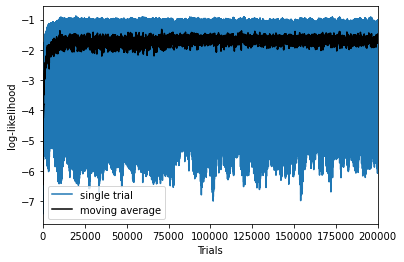

In [12]:
plt.figure()
plt.plot(log1.ll); plt.xlim(0, numN)
plt.plot(log1.m_ll, color='black');
plt.legend(['single trial', 'moving average'])
plt.xlabel('Trials')
plt.ylabel('log-likelihood')

last_nTrials = 10000
m_ll = log1.ll[-last_nTrials:].mean()
print(f'Mean log-likelihood over last {last_nTrials} trials: {m_ll}')

### Weights over trials

(0.0, 1.0)

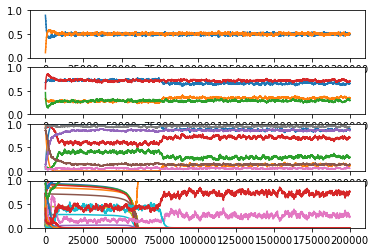

In [6]:
plt.figure()
plt.subplot(4, 1, 1); plt.plot(log1.A1.reshape((numN, -1))); plt.ylim([0, 1])
plt.subplot(4, 1, 2); plt.plot(log1.A2.reshape((numN, -1))); plt.ylim([0, 1])
plt.subplot(4, 1, 3); plt.plot(log1.A3.reshape((numN, -1))); plt.ylim([0, 1])
plt.subplot(4, 1, 4); plt.plot(log1.mu.reshape((numN, -1))); plt.ylim([0, 1])

### Final $\mu$

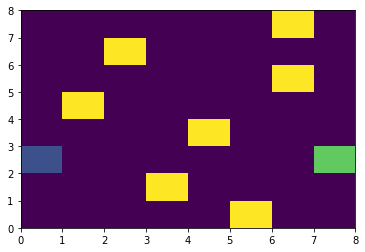

In [7]:
plt.figure()
plt.pcolormesh(model1.mu.reshape((-1, 8)), vmin=0, vmax=1)

## Intermediate conclusions

- The log-likelihood (stochastically) improves over trials, showing that the model gets better during training.
- The weights show convergence over time, after which they remain stochastically stable.
- The final $\mu$ match quite well with the correct model. Two things to note:
    - It's not an identity matrix. That is, the labels of the groups are shuffled. This is inherent of such a model, and is fine.
    - Two (or more) real groups in the data may be consumed by one group in the trained model, leaving one group virtually untrained. This indicates a local minimum.

Overall, the algorithms seems to work well.

# Sanity checks

## Initialize with correct parameters

When initializing the to-be-trained model with the same parameters as the model from which the data were sampled, then the parameters should barely change and the log-likelihood should be maximum.

$\mu$ is slightly adjusted, because absolute 0 leads to numerical problems.

In [13]:
# Parameters from true model
cfg = c.Cfg()
cfg.A1 = model0.A1
cfg.A2 = model0.A2
cfg.A3 = model0.A3
cfg.mu = model0.mu * 0.9999 + 0.00005

model2 = Model(cfg)

gamma = 0.001                            # Learning parameter

log2 = c.Empty()
log2.ll = np.zeros(numN)                 # Log-likelihood
log2.m_ll = np.zeros(numN)               # Moving average log-likelihood
log2.A1 = np.zeros((numN, 2))
log2.A2 = np.zeros((numN, 2, 2))
log2.A3 = np.zeros((numN, 2, 2, 2))
log2.mu = np.zeros((numN, 2, 2, 2, 8))

for nn in range(0, numN):
    log2.A1[nn, :] = model2.A1
    log2.A2[nn, :, :] = model2.A2
    log2.A3[nn, :, :, :] = model2.A3
    log2.mu[nn, :, :, :, :] = model2.mu

    x = X[nn, :]
    (p, ll) = model2.infer(x)
    log2.ll[nn] = ll
    log2.m_ll[nn] = log2.ll[max(0, nn-100):(nn+1)].mean()

    model2.learn(p, x, gamma)
    
    if (nn % 10000) == 0:
        print(f'Finished trial {nn}/{numN}')

Finished trial 0/200000
Finished trial 10000/200000
Finished trial 20000/200000
Finished trial 30000/200000
Finished trial 40000/200000
Finished trial 50000/200000
Finished trial 60000/200000
Finished trial 70000/200000
Finished trial 80000/200000
Finished trial 90000/200000
Finished trial 100000/200000
Finished trial 110000/200000
Finished trial 120000/200000
Finished trial 130000/200000
Finished trial 140000/200000
Finished trial 150000/200000
Finished trial 160000/200000
Finished trial 170000/200000
Finished trial 180000/200000
Finished trial 190000/200000


### Inspect

#### Log-likelihood over trials

Mean log-likelihood over last 10000 trials: -1.6993495476273293


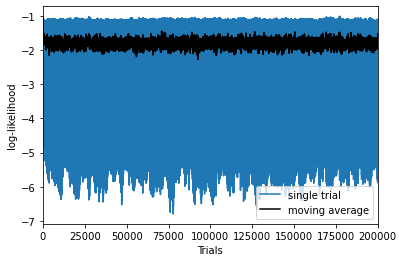

In [14]:
plt.figure()
plt.plot(log2.ll); plt.xlim(0, numN)
plt.plot(log2.m_ll, color='black');
plt.legend(['single trial', 'moving average'])
plt.xlabel('Trials')
plt.ylabel('log-likelihood')

last_nTrials = 10000
m_ll = log1.ll[-last_nTrials:].mean()
print(f'Mean log-likelihood over last {last_nTrials} trials: {m_ll}')

#### Weights over trials

(0.0, 1.0)

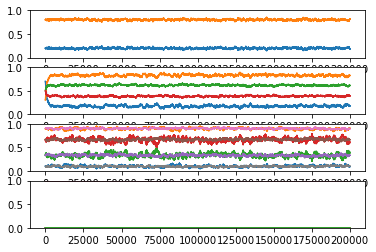

In [16]:
plt.figure()
plt.subplot(4, 1, 1); plt.plot(log2.A1.reshape((numN, -1))); plt.ylim([0, 1])
plt.subplot(4, 1, 2); plt.plot(log2.A2.reshape((numN, -1))); plt.ylim([0, 1])
plt.subplot(4, 1, 3); plt.plot(log2.A3.reshape((numN, -1))); plt.ylim([0, 1])
plt.subplot(4, 1, 4); plt.plot(log2.mu.reshape((numN, -1))); plt.ylim([0, 1])

#### Final $\mu$

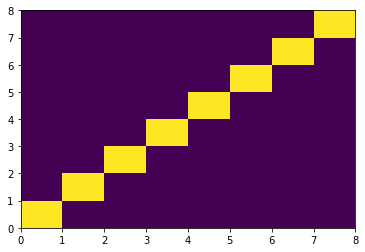

In [17]:
plt.figure()
plt.pcolormesh(model2.mu.reshape((-1, 8)), vmin=0, vmax=1)

### Intermediate conclusions

- The log-likelihood and all parameters remain stable during training, as expected.
- This analysis also gives a baseline for the global maximum of the log-likelihood.

# Conclusion

It seems that iteratively learning works well.